In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [89]:
os.chdir('C:\\Users\\Hp\\OneDrive\\Documents\\GitHub\\Thoucentric\\DataSets')

In [90]:
df=pd.read_csv('Iceus_sugar_all.csv')
df.head()

,datapoint_name,date,low,high,close,open
0,ICEUS Sugar #11 LOW,2017-01-03T00:00:00.000Z,19.58,20.55,20.51,19.63
1,ICEUS Sugar #11 LOW,2017-01-04T00:00:00.000Z,20.41,20.94,20.89,20.55
2,ICEUS Sugar #11 LOW,2017-01-05T00:00:00.000Z,20.66,21.18,20.78,20.89
3,ICEUS Sugar #11 LOW,2017-01-06T00:00:00.000Z,20.30,20.84,20.75,20.66
4,ICEUS Sugar #11 LOW,2017-01-09T00:00:00.000Z,20.36,20.75,20.42,20.74


In [91]:
df.index=pd.to_datetime(df['date'], format='ISO8601')
df=df.drop(columns=['date', 'datapoint_name'])
df.head()

,low,high,close,open
date,,,,
2017-01-03 00:00:00+00:00,19.58,20.55,20.51,19.63
2017-01-04 00:00:00+00:00,20.41,20.94,20.89,20.55
2017-01-05 00:00:00+00:00,20.66,21.18,20.78,20.89
2017-01-06 00:00:00+00:00,20.30,20.84,20.75,20.66
2017-01-09 00:00:00+00:00,20.36,20.75,20.42,20.74


In [92]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [93]:
windowsize=5
X, y= df_to_X_y(df, windowsize)
X.shape, y.shape

((2067, 5, 1, 4), (2067, 4))

In [94]:
X=X.reshape(X.shape[0], X.shape[1], X.shape[3])
X.shape, y.shape

((2067, 5, 4), (2067, 4))

In [95]:
X_train, y_train = X[:1800], y[:1800]
X_val, y_val = X[1800:1950], y[1800:1950]
X_test, y_test = X[1950:], y[1950:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1800, 5, 4), (1800, 4), (150, 5, 4), (150, 4), (117, 5, 4), (117, 4))

In [96]:
from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

In [97]:
model = Sequential()
model.add(InputLayer((windowsize, X_train.shape[2])))  # (5, 4)
model.add(LSTM(64))
model.add(Dense(8, activation='relu'))
model.add(Dense(y_train.shape[1], activation='linear'))  # 15 features in the output
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                17664     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 4)                 36        
                                                                 
Total params: 18,220
Trainable params: 18,220
Non-trainable params: 0
_________________________________________________________________


In [98]:
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=110)

Epoch 1/110
57/57 [==============================] - 2s 10ms/step - loss: 269.3752 - root_mean_squared_error: 16.4127 - val_loss: 549.9183 - val_root_mean_squared_error: 23.4503
Epoch 2/110
57/57 [==============================] - 0s 3ms/step - loss: 215.9486 - root_mean_squared_error: 14.6952 - val_loss: 428.8277 - val_root_mean_squared_error: 20.7082
Epoch 3/110
57/57 [==============================] - 0s 3ms/step - loss: 115.3544 - root_mean_squared_error: 10.7403 - val_loss: 237.6734 - val_root_mean_squared_error: 15.4167
Epoch 4/110
57/57 [==============================] - 0s 3ms/step - loss: 45.3461 - root_mean_squared_error: 6.7339 - val_loss: 127.9228 - val_root_mean_squared_error: 11.3103
Epoch 5/110
57/57 [==============================] - 0s 3ms/step - loss: 23.4830 - root_mean_squared_error: 4.8459 - val_loss: 86.8996 - val_root_mean_squared_error: 9.3220
Epoch 6/110
57/57 [==============================] - 0s 3ms/step - loss: 17.5274 - root_mean_squared_error: 4.1866 - val

In [99]:
train_predictions = model.predict(X_train).flatten()
ytrain1= y_train.flatten()
train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals': ytrain1})
train_results

57/57 [==============================] - 0s 1ms/step


,Train Predictions,Actuals
0,20.108419,20.15
1,20.582560,20.56
2,20.334787,20.48
3,20.309111,20.50
4,20.108297,20.48
...,...,...
7195,25.985775,26.24
7196,25.748774,25.95
7197,26.462412,26.85
7198,26.125099,26.73


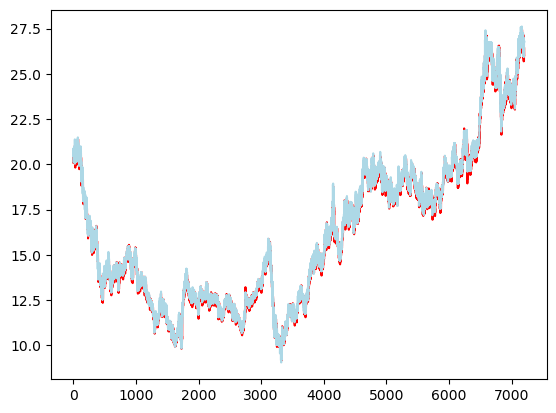

In [100]:
plt.plot(train_results['Train Predictions'][:], color= 'red')
plt.plot(train_results['Actuals'][:], color= 'lightblue')

In [101]:
val_predictions= model.predict(X_val).flatten()
y_val1=y_val.flatten()
val_results=pd.DataFrame(data={'Val Predictions': val_predictions, 'Val Actuals': y_val1})
val_results

5/5 [==============================] - 0s 1ms/step


,Val Predictions,Val Actuals
0,26.133177,26.20
1,26.851637,26.80
2,26.516092,26.27
3,26.399200,26.77
4,25.995342,26.20
...,...,...
595,22.541451,22.70
596,22.356373,22.56
597,22.914568,23.08
598,22.638622,22.62


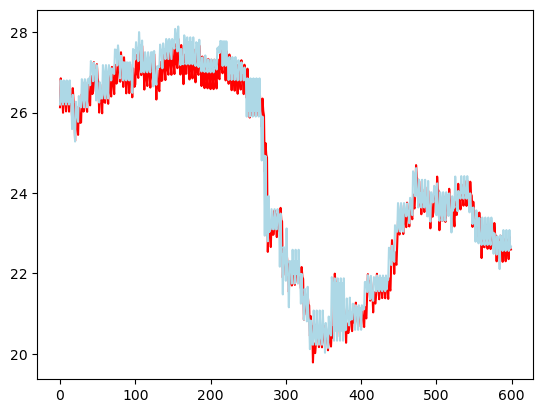

In [102]:
plt.plot(val_results['Val Predictions'][:], color='red')
plt.plot(val_results['Val Actuals'][:], color='lightblue')

In [103]:
test_predictions = model.predict(X_test).flatten()
ytest1=y_test.flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Test Actuals': ytest1})
test_results

4/4 [==============================] - 0s 2ms/step


,Test Predictions,Test Actuals
0,22.329098,22.45
1,22.886421,23.45
2,22.609976,23.15
3,22.568514,23.24
4,22.842709,23.12
...,...,...
463,18.863008,18.92
464,18.643742,18.81
465,19.077856,19.06
466,18.855017,18.97


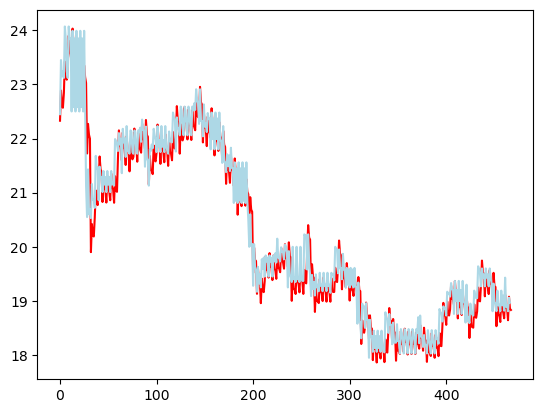

In [104]:
plt.plot(test_results['Test Predictions'][:], color='red')
plt.plot(test_results['Test Actuals'][:], color='lightblue')